
--- ExpectedSARSA: Basic Strategy ---
Training for 200000 episodes...
ExpectedSARSA Training 200000/200000
Training completed in 16.0 seconds

----------------------------------------
Win rate: 41.89%
Loss rate: 48.18%
Draw rate: 9.93%
Average profit per game: -0.06
ROI: -0.06

--- MonteCarlo: Basic Strategy ---
Training for 300000 episodes...
MonteCarlo Training 300000/300000
Training completed in 225.4 seconds

----------------------------------------
Win rate: 41.67%
Loss rate: 49.24%
Draw rate: 9.09%
Average profit per game: -0.08
ROI: -0.08

--- ExpectedSARSA: CPC ---
Training for 200000 episodes...
ExpectedSARSA Training 200000/200000
Training completed in 16.1 seconds

----------------------------------------
Win rate: 41.76%
Loss rate: 49.32%
Draw rate: 8.92%
Average profit per game: -0.11
ROI: -0.11

--- MonteCarlo: CPC ---
Training for 300000 episodes...
MonteCarlo Training 300000/300000
Training completed in 73.8 seconds

----------------------------------------
Win rate: 4

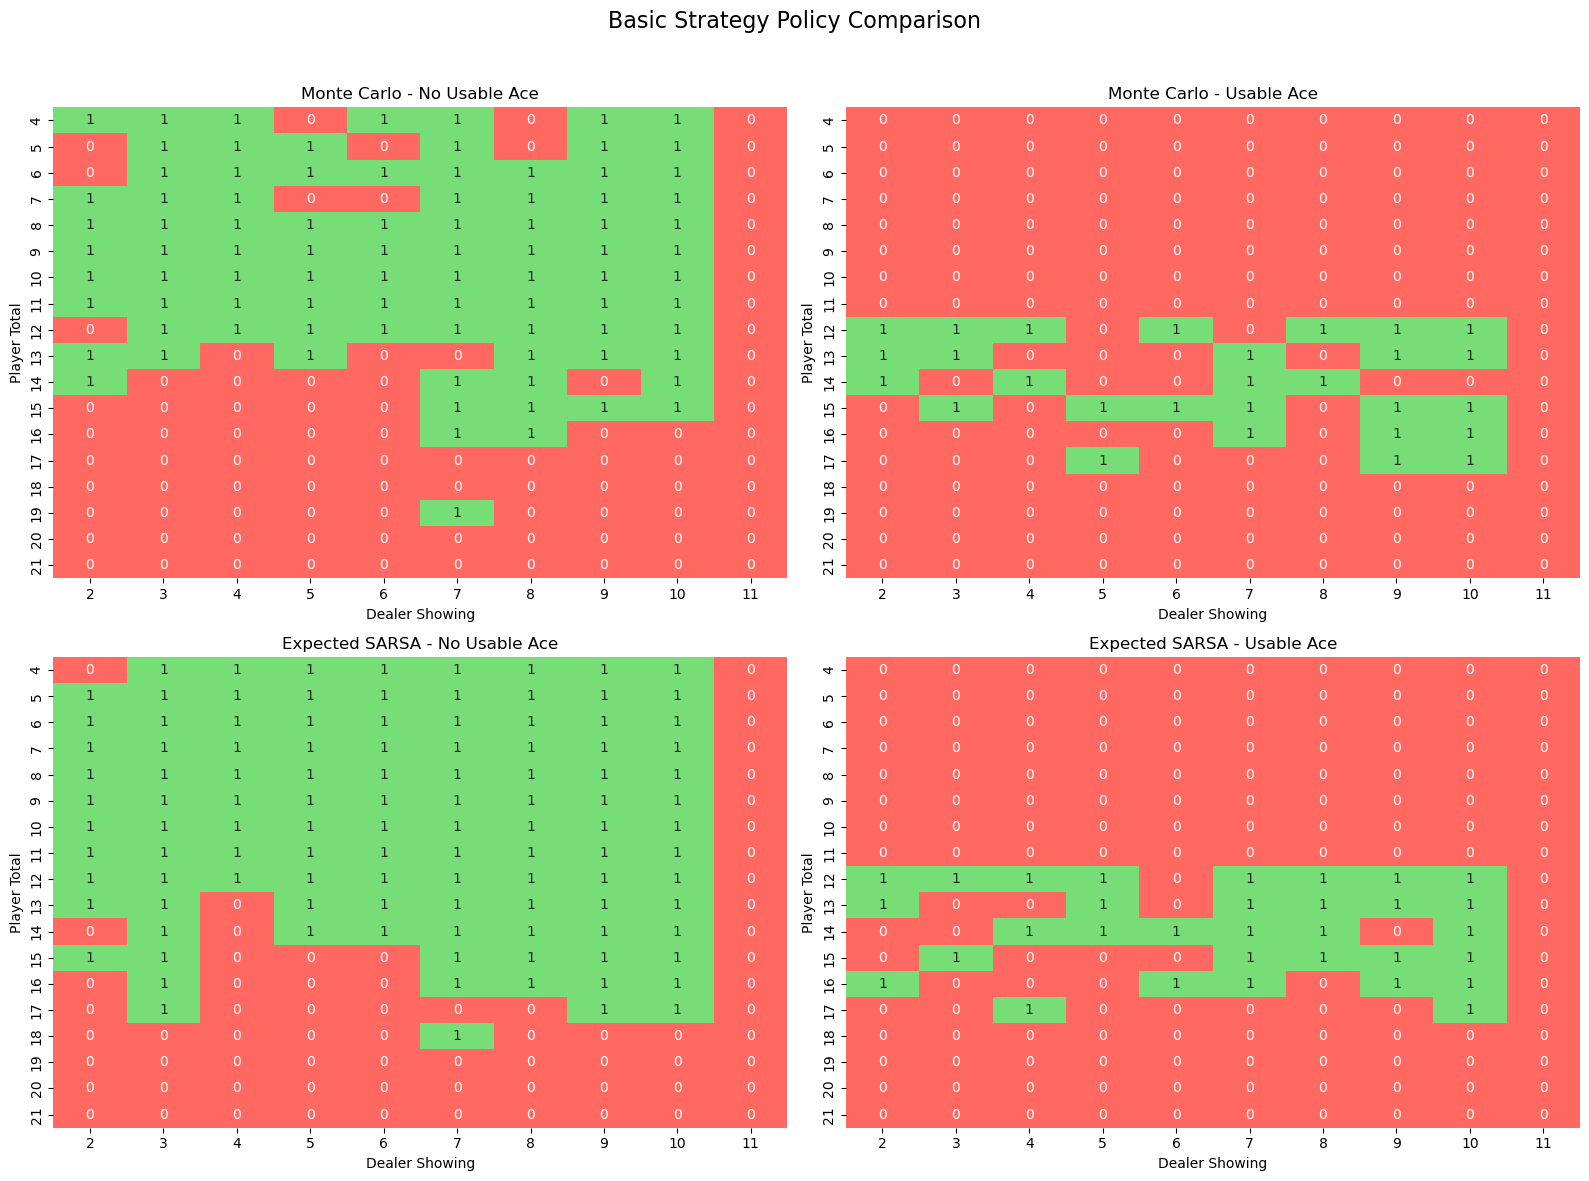

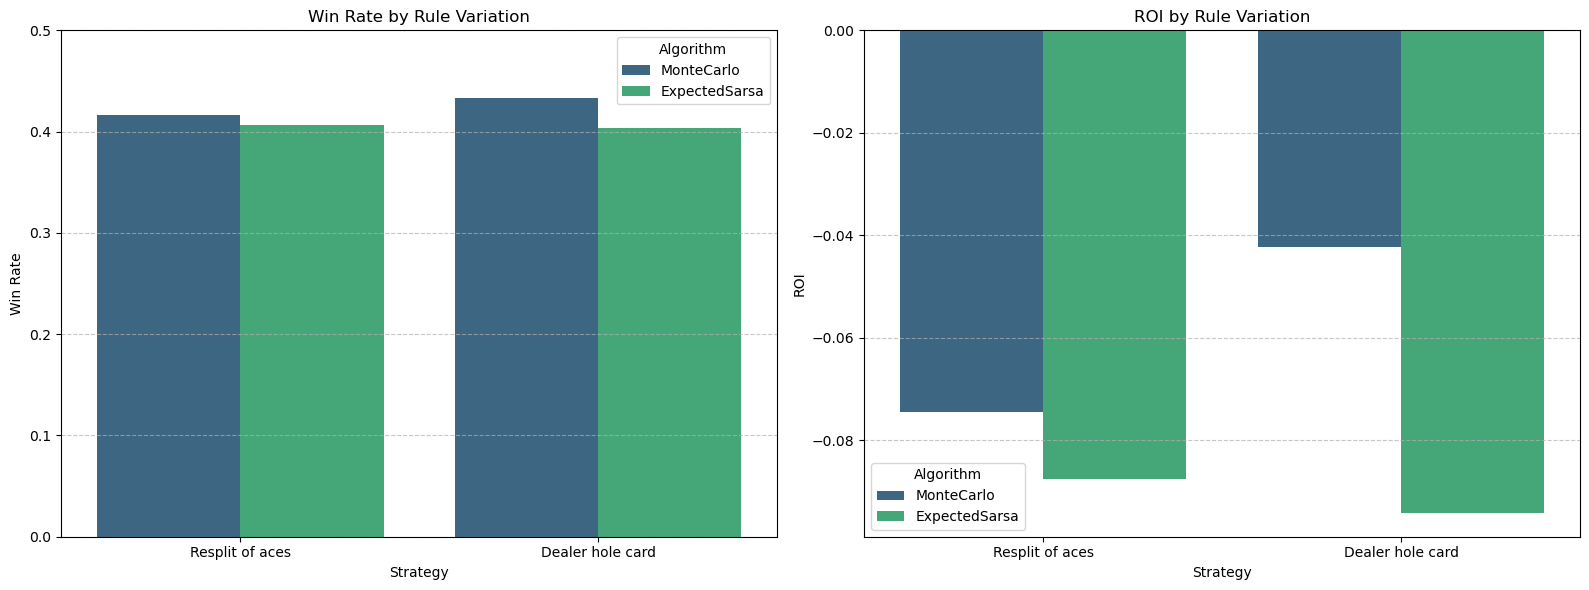

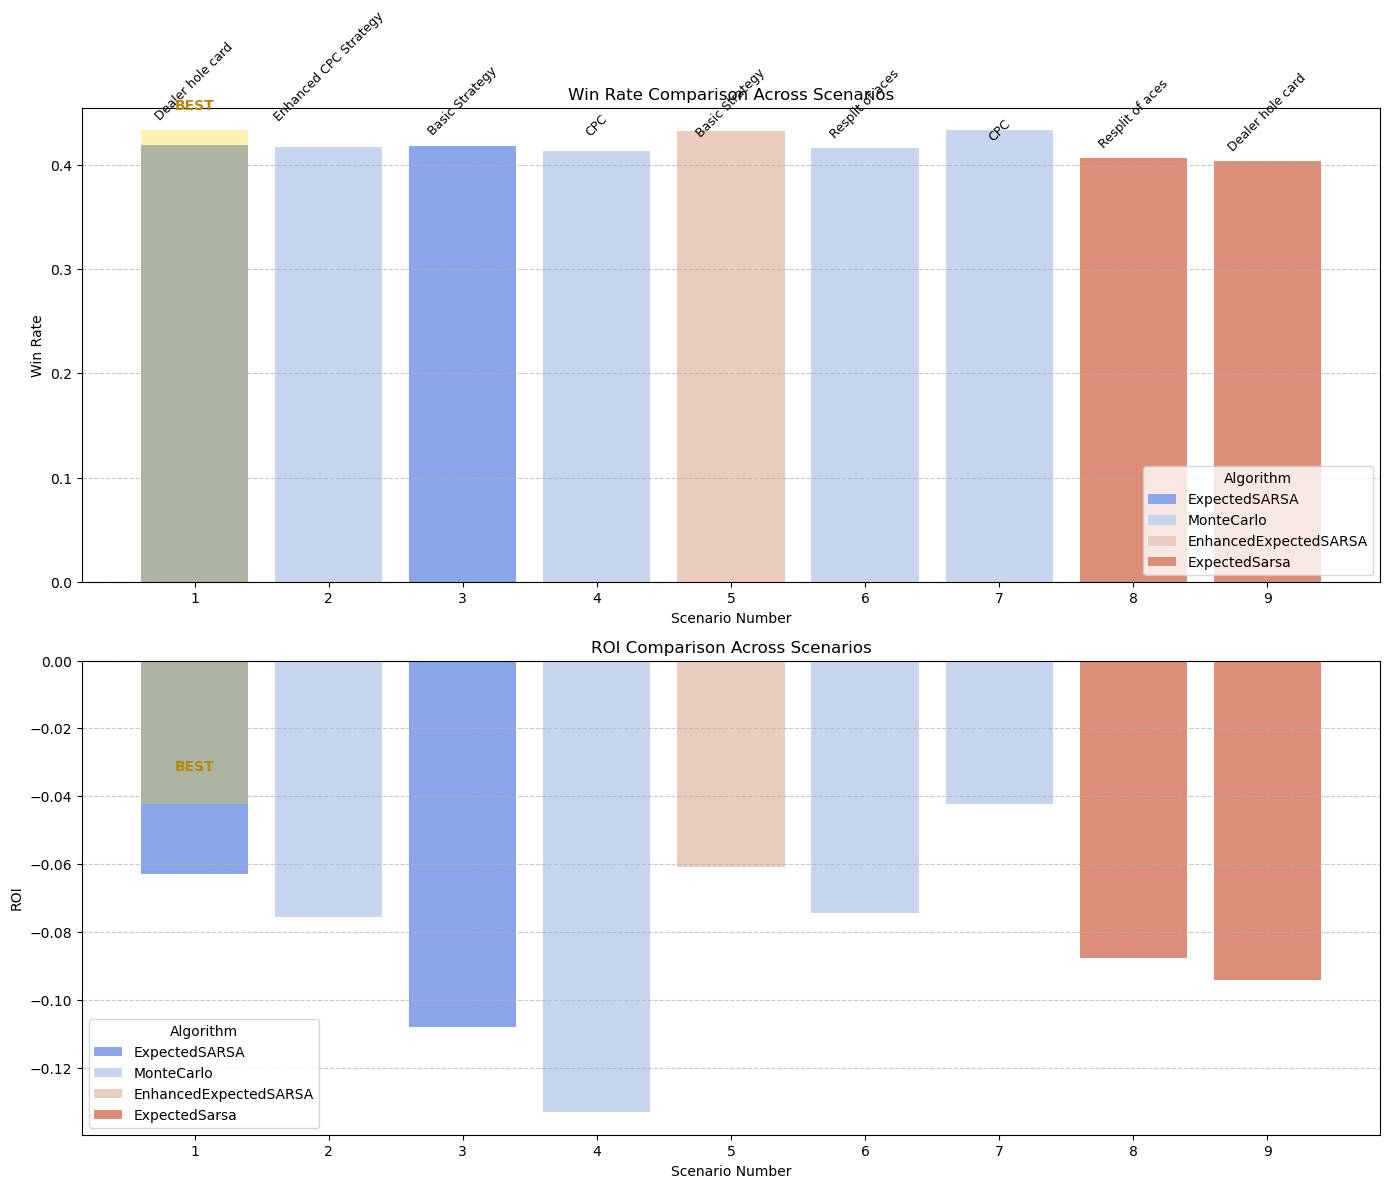

In [1]:
import numpy as np
import random
from collections import defaultdict
import time
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap


class BlackjackEnv:
    def __init__(self, decks=1, dealer_hits_soft17=False, blackjack_payout=1.5, use_cpc=False, resplit_aces=False, dealer_shows_hole=False):
        self.decks = decks
        self.dealer_hits_soft17 = dealer_hits_soft17
        self.blackjack_payout = blackjack_payout
        self.use_cpc = use_cpc
        self.resplit_aces = resplit_aces
        self.dealer_shows_hole = dealer_shows_hole
        
        self.deck = self._create_deck()
        self.running_count = 0
        self.true_count_bins = [-5, 0, 2, 5]
        
        self.reset()


    def _create_deck(self):
        deck = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4 * self.decks
        random.shuffle(deck)
        return deck

    def _update_count(self, card):
        if card in [2, 3, 4, 5, 6]:
            self.running_count += 1
        elif card in [10, 1]:
            self.running_count -= 1

    def _get_true_count(self):
        decks_remaining = max(len(self.deck) / 52.0, 1)
        return round(self.running_count / decks_remaining)

    def _hand_value(self, hand):
        total = sum(hand)
        ace_as_eleven = hand.count(1)
        while ace_as_eleven > 0 and total + 10 <= 21:
            total += 10
            ace_as_eleven -= 1
        return total, ace_as_eleven > 0

    def reset(self):
        if len(self.deck) < 15:
            self.deck = self._create_deck()
            self.running_count = 0

        self.player_hand = [self.deck.pop(), self.deck.pop()]
        self.dealer_hand = [self.deck.pop(), self.deck.pop()]

        for card in self.player_hand + self.dealer_hand:
            self._update_count(card)

        self.current_bet = 1
        if self.use_cpc:
            true_count = self._get_true_count()
            if true_count >= 4:
                self.current_bet = 4
            elif true_count >= 2:
                self.current_bet = 2

        return self._get_state(), 0, False

    def _get_state(self):
        player_sum, usable_ace = self._hand_value(self.player_hand)
        dealer_card = self.dealer_hand[0]
        if self.use_cpc:
            true_count = self._get_true_count()
            for i, val in enumerate(self.true_count_bins):
                if true_count < val:
                    return (player_sum, usable_ace, dealer_card, i)
            return (player_sum, usable_ace, dealer_card, len(self.true_count_bins))
        else:
            return (player_sum, usable_ace, dealer_card)

    def step(self, action):
        """
        Performs a single step in the environment given an action.
        Action 1: Hit, Action 0: Stand.
        Returns the next state, reward, and done status.
        """
        bet = self.current_bet

        if action == 1:  # Hit
            if not self.deck:
                self.deck = self._create_deck()
                self.running_count = 0
            card = self.deck.pop()
            self.player_hand.append(card)
            self._update_count(card)
            player_sum, _ = self._hand_value(self.player_hand)
            if player_sum > 21:
                return self._get_state(), -1 * bet, True
            return self._get_state(), 0, False
        else:  # Stand
            hole_card = self.dealer_hand[1]
            self._update_count(hole_card)
            return self._dealer_play(bet)

    def _dealer_play(self, bet=1):
        dealer_sum, _ = self._hand_value(self.dealer_hand)
        while dealer_sum < 17 or (dealer_sum == 17 and self.dealer_hits_soft17 and any(card == 1 for card in self.dealer_hand)):
            if not self.deck:
                self.deck = self._create_deck()
                self.running_count = 0
            card = self.deck.pop()
            self.dealer_hand.append(card)
            self._update_count(card)
            dealer_sum, _ = self._hand_value(self.dealer_hand)

        player_sum, _ = self._hand_value(self.player_hand)

        if dealer_sum > 21 or player_sum > dealer_sum:
            reward = 1 * bet
        elif player_sum == dealer_sum:
            reward = 0
        else:
            reward = -1 * bet

        return self._get_state(), reward, True

class RLAgent:
    """
    Base class for Reinforcement Learning agents (ExpectedSARSA, Monte Carlo).
    Implements common functionalities like Q-table, epsilon-greedy action selection.
    """
    def __init__(self, algorithm, alpha=0.1, gamma=0.95, epsilon=0.1, epsilon_decay=1.0):
        self.algorithm = algorithm  
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = epsilon  
        self.epsilon_decay = epsilon_decay  
        self.Q = defaultdict(lambda: np.zeros(2))  
        self.actions = [0, 1]  
        self.train_mode = True  
    
    def set_train_mode(self):
        """Sets the agent to training mode (enables exploration)."""
        self.train_mode = True
    
    def set_eval_mode(self):
        """Sets the agent to evaluation mode (disables exploration)."""
        self.train_mode = False
    
    def act(self, state):
        """
        Selects an action using an epsilon-greedy policy during training,
        and a greedy policy during evaluation.
        """
        if self.train_mode and random.random() < self.epsilon:
            return random.choice(self.actions)  
        return np.argmax(self.Q[state])  
    
    def learn(self, state, action, reward, next_state, done):
        """
        Abstract method for learning. Implemented by subclasses based on the RL algorithm.
        """
        raise NotImplementedError("Learn method must be implemented by subclass")

    def decay_epsilon(self):
        """Decays the epsilon value after each episode."""
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

class ExpectedSarsaAgent(RLAgent):
    """
    Expected SARSA agent.
    An off-policy TD control algorithm that computes the expected value of the next state.
    """
    def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.1, epsilon_decay=1.0):
        super().__init__("ExpectedSARSA", alpha, gamma, epsilon, epsilon_decay=epsilon_decay)
    
    def learn(self, state, action, reward, next_state, done):
        """
        Expected SARSA update rule.
        Q(S,A) = Q(S,A) + alpha * [R + gamma * E[Q(S',A)] - Q(S,A)]
        """
        current_q = self.Q[state][action]
        if done:
            target = reward
        else:
            # Calculate expected value of next state
            max_q = np.max(self.Q[next_state])
            mean_q = np.mean(self.Q[next_state])
            expected_value = (1 - self.epsilon) * max_q + self.epsilon * mean_q
            target = reward + self.gamma * expected_value
        
        self.Q[state][action] += self.alpha * (target - current_q)

class EnhancedExpectedSarsaAgent(ExpectedSarsaAgent):
    """
    Enhanced Expected SARSA agent with:
    - Adaptive learning rate (alpha decay)
    - Optimistic initial values
    - Dynamic epsilon scheduling
    - Win-rate-based early stopping
    """
    def __init__(self, alpha=0.15, gamma=0.99, epsilon_start=0.7, 
                 epsilon_decay=0.999998, alpha_decay=0.999995, 
                 alpha_min=0.01, optimistic_init=1.0):
        super().__init__(alpha=alpha, gamma=gamma, epsilon=epsilon_start, 
                         epsilon_decay=epsilon_decay)
        self.alpha_start = alpha
        self.alpha_decay = alpha_decay
        self.alpha_min = alpha_min
        self.optimistic_init = optimistic_init
        self.best_win_rate = -1
        self.stagnation_count = 0
        self.Q = defaultdict(lambda: np.full(2, optimistic_init))
        
    def decay_epsilon(self):
        """Decay epsilon and learning rate"""
        super().decay_epsilon()  # Decays epsilon
        self.alpha = max(self.alpha_min, self.alpha * self.alpha_decay)
        
    def update_convergence_stats(self, win_rate):
        """Track performance for early stopping"""
        if win_rate > self.best_win_rate:
            self.best_win_rate = win_rate
            self.stagnation_count = 0
        else:
            self.stagnation_count += 1

    def should_stop_early(self):
        """Early stop if performance plateaus"""
        return self.stagnation_count > 20

# class SarsaAgent(RLAgent):
#     """
#     SARSA (State-Action-Reward-State-Action) agent.
#     An on-policy TD control algorithm.
#     """
#     def __init__(self, alpha=0.1, gamma=0.95, epsilon=0.1, epsilon_decay=1.0):
#         super().__init__("SARSA", alpha, gamma, epsilon, epsilon_decay=epsilon_decay)
    
#     def learn(self, state, action, reward, next_state, done):
#         """
#         SARSA update rule.
#         Q(S,A) = Q(S,A) + alpha * [R + gamma * Q(S',A') - Q(S,A)]
#         """
#         next_action = self.act(next_state)  
#         td_target = reward + (0 if done else self.gamma * self.Q[next_state][next_action])
#         self.Q[state][action] += self.alpha * (td_target - self.Q[state][action])


# class EnhancedSarsaAgent(SarsaAgent):
#     """
#     Enhanced SARSA agent with epsilon decay for potentially better convergence.
#     """
#     def __init__(self, alpha=0.1, gamma=0.95, epsilon_start=0.5, epsilon_decay=0.999995):
#         super().__init__(alpha=alpha, gamma=gamma, epsilon=epsilon_start, epsilon_decay=epsilon_decay)
#         self.epsilon_start = epsilon_start


class MonteCarloAgent(RLAgent):
    """
    Monte Carlo (First-Visit) agent.
    Learns from complete episodes.
    """
    def __init__(self, gamma=0.95, epsilon=0.1, epsilon_decay=1.0):
        super().__init__("MonteCarlo", gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay)
        self.episode_trajectory = [] # Stores (state, action, reward) for current episode
        self.returns = defaultdict(list) # For Monte Carlo: (s,a) -> list of returns
    
    def learn(self, state, action, reward, next_state, done):
        """
        Collects episode trajectory and performs Monte Carlo update at the end of an episode.
        """
        self.episode_trajectory.append((state, action, reward))
        if done:
            self._update_mc()
    
    def _update_mc(self):
        """
        Performs First-Visit Monte Carlo Q-value update.
        """
        G = 0  
        visited_sa = set()  
        
        for t in reversed(range(len(self.episode_trajectory))):
            state, action, reward = self.episode_trajectory[t]
            G = self.gamma * G + reward
            
            if (state, action) not in visited_sa:
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])
                visited_sa.add((state, action))
        self.episode_trajectory = []  

# class EnhancedMonteCarloAgent(MonteCarloAgent):
#     """
#     Enhanced Monte Carlo agent with epsilon decay for potentially better convergence.
#     """
#     def __init__(self, gamma=0.95, epsilon_start=0.5, epsilon_decay=0.999995):
#         super().__init__(gamma=gamma, epsilon=epsilon_start, epsilon_decay=epsilon_decay)
#         self.epsilon_start = epsilon_start

# class EnhancedSarsaAgentV2(SarsaAgent):
#     """
#     Enhanced SARSA agent with:
#     - Adaptive learning rate (alpha decay)
#     - Optimistic initial values
#     - Dynamic epsilon scheduling
#     - Win-rate-based early stopping
#     """
#     def __init__(self, alpha=0.15, gamma=0.99, epsilon_start=0.7, 
#                      epsilon_decay=0.999998, alpha_decay=0.999995, 
#                      alpha_min=0.01, optimistic_init=1.0):
#         super().__init__(alpha=alpha, gamma=gamma, epsilon=epsilon_start, 
#                              epsilon_decay=epsilon_decay)
#         self.alpha_start = alpha
#         self.alpha_decay = alpha_decay
#         self.alpha_min = alpha_min
#         self.optimistic_init = optimistic_init
#         self.best_win_rate = -1
#         self.stagnation_count = 0
#         self.Q = defaultdict(lambda: np.full(2, optimistic_init))
        
#     def decay_epsilon(self):
#         """Decay epsilon and learning rate"""
#         super().decay_epsilon()
#         self.alpha = max(self.alpha_min, self.alpha * self.alpha_decay)
        
#     def update_convergence_stats(self, win_rate):
#         """Track performance for early stopping"""
#         if win_rate > self.best_win_rate:
#             self.best_win_rate = win_rate
#             self.stagnation_count = 0
#         else:
#             self.stagnation_count += 1

#     def should_stop_early(self):
#         """Early stop if performance plateaus"""
#         return self.stagnation_count > 20

def train_agent(agent, env, algo_name, scenario_name, episodes=100000):
    """
    Trains a given RL agent in the Blackjack environment for a specified number of episodes.
    Prints progress and calls evaluation at the end.
    """
    start_time = time.time()
    print(f"\n--- {algo_name}: {scenario_name} ---")
    print(f"Training for {episodes} episodes...")
    
    agent.set_train_mode()  
    
    for ep in range(episodes):
        state, reward_initial, done_initial = env.reset()  
        
        if done_initial:
            if isinstance(agent, ExpectedSarsaAgent):
                agent.learn(state, 0, reward_initial, state, True)  
            elif isinstance(agent, MonteCarloAgent):
                agent.episode_trajectory.append((state, 0, reward_initial)) 
                agent.learn(state, 0, reward_initial, state, True) 
        else:
            done = False
            while not done:
                action = agent.act(state)
                next_state, reward, done = env.step(action)
                agent.learn(state, action, reward, next_state, done)
                state = next_state
        
        if hasattr(agent, 'epsilon_decay') and agent.epsilon_decay < 1.0:
            agent.decay_epsilon()
            
        # Print training progress
        if (ep + 1) % (episodes // 10) == 0 or ep == episodes - 1:
            print(f"\r{algo_name} Training {ep+1}/{episodes}", end="")
    
    print(f"\nTraining completed in {time.time()-start_time:.1f} seconds")
    # Only call evaluate_full once after training is complete
    return evaluate_full(agent, env)

def evaluate_full(agent, env, num_games=10000):
    """
    Evaluates the trained RL agent over a specified number of games.
    Calculates and prints win rate, loss rate, draw rate, average profit per game, and ROI.
    """
    agent.set_eval_mode()  
    wins = 0
    losses = 0
    draws = 0
    total_profit = 0
    
    for _ in range(num_games):
        state, reward, done = env.reset()  
        
        if not done:  
            while not done:
                action = agent.act(state)
                state, reward, done = env.step(action)
        
        total_profit += reward
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    
    total_games = wins + losses + draws
    win_rate = wins / total_games
    loss_rate = losses / total_games
    draw_rate = draws / total_games
    avg_profit = total_profit / total_games
    roi = total_profit / num_games  
    
    print("\n----------------------------------------")
    print(f"Win rate: {win_rate:.2%}")  
    print(f"Loss rate: {loss_rate:.2%}")  
    print(f"Draw rate: {draw_rate:.2%}")  
    print(f"Average profit per game: {avg_profit:.2f}")
    print(f"ROI: {roi:.2f}")
    
    agent.set_train_mode()  
    return win_rate, roi

# Main execution block
if __name__ == "__main__":
    # Base environment configuration
    base_config = {
        'decks': 6,
        'dealer_hits_soft17': False,  
        'blackjack_payout': 1.5,  
        'use_cpc': False
    }
    
    # Define scenarios
    scenarios = [
       
         # Scenario 1: Expected SARSA - Basic Strategy
        {
            "scenario_num": 1,
            "algo": "ExpectedSARSA",
            "agent": ExpectedSarsaAgent(alpha=0.08, epsilon=0.08, epsilon_decay=0.99999),
            "env_config": base_config.copy(),
            "name": "Basic Strategy",
            "episodes": 200000
        },
        
         # Scenario 2: Monte Carlo - Basic Strategy
        {
            "scenario_num": 2,
            "algo": "MonteCarlo",
            "agent": MonteCarloAgent(gamma=0.98, epsilon=0.1, epsilon_decay=0.99999),  
            "env_config": base_config.copy(),
            "name": "Basic Strategy",
            "episodes": 300000  
        },

        # Scenario 3: Expected SARSA - CPC System
        {
            "scenario_num": 3,
            "algo": "ExpectedSARSA",
            "agent": ExpectedSarsaAgent(alpha=0.07, epsilon=0.07, epsilon_decay=0.99999),
            "env_config": base_config.copy(),
            "name": "CPC",
            "modify": lambda c: c.update({'use_cpc': True}),
            "episodes": 200000
        },
               
        # Scenario 4: Monte Carlo - CPC System
        {
            "scenario_num": 4,
            "algo": "MonteCarlo",
            "agent": MonteCarloAgent(gamma=0.99, epsilon=0.08, epsilon_decay=0.999997),
            "env_config": base_config.copy(),
            "name": "CPC",
            "modify": lambda c: c.update({'use_cpc': True}),
            "episodes": 300000
        },

        # New Scenario 5: EnhancedExpectedSARSA - CPC System
        {
            "scenario_num": 5,
            "algo": "EnhancedExpectedSARSA",
            "agent": EnhancedExpectedSarsaAgent(
                    alpha=0.15,
                    gamma=0.995,
                    epsilon_start=0.7,
                    epsilon_decay=0.999999,  # Slower decay
                    alpha_decay=0.999996,
                    alpha_min=0.005,
                    optimistic_init=1.5  # More optimistic
                ),
            "env_config": {
            'decks': 6,
            'dealer_hits_soft17': False,
            'blackjack_payout': 1.5,
            'use_cpc': True,
            'resplit_aces': True,
            'dealer_shows_hole': True
            },
            "name": "Enhanced CPC Strategy",
            "modify": lambda c: c.update({'use_cpc': True}),
            "episodes": 1000000
        },
          
        # Scenario 6: Monte Carlo - Resplit of aces
        {
            "scenario_num": 6,
            "algo": "MonteCarlo",
            "agent": MonteCarloAgent(gamma=0.98, epsilon=0.1, epsilon_decay=0.99999),
            "env_config": base_config.copy(),
            "name": "Resplit of aces",
            "modify": lambda c: c.update({'resplit_aces': True}),
            "episodes": 300000
        },
        
        # Scenario 7: Monte Carlo - Dealer hole card visible
        {
            "scenario_num": 7,
            "algo": "MonteCarlo",
            "agent": MonteCarloAgent(gamma=0.98, epsilon=0.1, epsilon_decay=0.99999),
            "env_config": base_config.copy(),
            "name": "Dealer hole card", 
            "modify": lambda c: c.update({'dealer_shows_hole': True}),
            "episodes": 300000
        },        
      
        # Scenario 8: Expected Sarsa - Resplit of aces
        {
            "scenario_num": 8,
            "algo": "ExpectedSarsa",
            "agent": ExpectedSarsaAgent(gamma=0.98, epsilon=0.1, epsilon_decay=0.99999),
            "env_config": base_config.copy(),
            "name": "Resplit of aces",
            "modify": lambda c: c.update({'resplit_aces': True}),
            "episodes": 300000
        },
        
        # Scenario 9: Expectes sarsa - Dealer hole card visible
        {
            "scenario_num": 9,
            "algo": "ExpectedSarsa",
            "agent": ExpectedSarsaAgent(gamma=0.98, epsilon=0.1, epsilon_decay=0.99999),
            "env_config": base_config.copy(),
            "name": "Dealer hole card", 
            "modify": lambda c: c.update({'dealer_shows_hole': True}),
            "episodes": 300000
        }
    ]
    
    results = []
    
    for scenario in scenarios:  
        if 'modify' in scenario:
            scenario['modify'](scenario['env_config'])
        
        env = BlackjackEnv(**scenario['env_config'])
        
        episodes = scenario.get('episodes', 100000)
        
        win_rate, roi = train_agent(
            agent=scenario['agent'],
            env=env,
            algo_name=scenario['algo'],
            scenario_name=scenario['name'],
            episodes=episodes
        )

        results.append({
            "Scenario #": scenario['scenario_num'],  
            "Algorithm": scenario['algo'],
            "Strategy": scenario['name'],
            "Win Rate": win_rate,
            "ROI": roi
        })
    
    print("\n===== FINAL RESULTS =====")
    # 📊 Plot performance comparison after all training
   
    print(f"{'Scenario':<10} | {'Algorithm':<18} | {'Strategy':<30} | {'Win Rate':<10} | {'ROI':<6}") 
    print("-" * 85) 
    for r in results:
        print(f"{r['Scenario #']:<10} | {r['Algorithm']:<18} | {r['Strategy']:<30} | {r['Win Rate']:.2%}   | {r['ROI']:.4f}")

    results_df = pd.DataFrame(results)

# 1. Heatmaps for Basic Strategy (MC and Expected SARSA)
def plot_basic_strategy_heatmaps():
    # For Monte Carlo (Scenario 2)
    agent_mc = scenarios[1]['agent']  # MC basic strategy
    # For Expected SARSA (Scenario 1)
    agent_sarsa = scenarios[0]['agent']  # SARSA basic strategy
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Basic Strategy Policy Comparison', fontsize=16)
    
    # Generate policy grids
    def get_policy_grid(agent):
        grid_no_ace = np.zeros((18, 10))  # Player 4-21, Dealer 2-11
        grid_ace = np.zeros((18, 10))
        
        for player_sum in range(4, 22):
            for dealer_card in range(2, 12):
                for usable_ace in [False, True]:
                    state = (player_sum, usable_ace, dealer_card)
                    action = agent.act(state)
                    row = player_sum - 4
                    col = dealer_card - 2
                    
                    if usable_ace:
                        grid_ace[row, col] = action
                    else:
                        grid_no_ace[row, col] = action
        return grid_no_ace, grid_ace

    # Monte Carlo heatmaps
    mc_no_ace, mc_ace = get_policy_grid(agent_mc)
    sns.heatmap(mc_no_ace, ax=axes[0, 0], cmap=ListedColormap(['#FF6961', '#77DD77']), 
                cbar=False, annot=True, fmt=".0f", 
                xticklabels=list(range(2, 12)), yticklabels=list(range(4, 22)))
    axes[0, 0].set_title('Monte Carlo - No Usable Ace')
    axes[0, 0].set_xlabel('Dealer Showing')
    axes[0, 0].set_ylabel('Player Total')
    
    sns.heatmap(mc_ace, ax=axes[0, 1], cmap=ListedColormap(['#FF6961', '#77DD77']), 
                cbar=False, annot=True, fmt=".0f", 
                xticklabels=list(range(2, 12)), yticklabels=list(range(4, 22)))
    axes[0, 1].set_title('Monte Carlo - Usable Ace')
    axes[0, 1].set_xlabel('Dealer Showing')
    axes[0, 1].set_ylabel('Player Total')

    # SARSA heatmaps
    sarsa_no_ace, sarsa_ace = get_policy_grid(agent_sarsa)
    sns.heatmap(sarsa_no_ace, ax=axes[1, 0], cmap=ListedColormap(['#FF6961', '#77DD77']), 
                cbar=False, annot=True, fmt=".0f", 
                xticklabels=list(range(2, 12)), yticklabels=list(range(4, 22)))
    axes[1, 0].set_title('Expected SARSA - No Usable Ace')
    axes[1, 0].set_xlabel('Dealer Showing')
    axes[1, 0].set_ylabel('Player Total')
    
    sns.heatmap(sarsa_ace, ax=axes[1, 1], cmap=ListedColormap(['#FF6961', '#77DD77']), 
                cbar=False, annot=True, fmt=".0f", 
                xticklabels=list(range(2, 12)), yticklabels=list(range(4, 22)))
    axes[1, 1].set_title('Expected SARSA - Usable Ace')
    axes[1, 1].set_xlabel('Dealer Showing')
    axes[1, 1].set_ylabel('Player Total')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig('basic_strategy_heatmaps.png')
    plt.show()

# 2. Rule Variation Comparison
def plot_rule_variations():
    # Filter rule variation results
    rule_variations = results_df[results_df['Strategy'].isin(['Resplit of aces', 'Dealer hole card'])]
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Win Rate Comparison
    sns.barplot(data=rule_variations, x='Strategy', y='Win Rate', hue='Algorithm', 
                palette='viridis', ax=ax[0])
    ax[0].set_title('Win Rate by Rule Variation')
    ax[0].set_ylabel('Win Rate')
    ax[0].set_ylim(0, 0.5)
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # ROI Comparison
    sns.barplot(data=rule_variations, x='Strategy', y='ROI', hue='Algorithm', 
                palette='viridis', ax=ax[1])
    ax[1].set_title('ROI by Rule Variation')
    ax[1].set_ylabel('ROI')
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('rule_variations_comparison.png')
    plt.show()

# 3. Performance Analysis (All Scenarios)
def plot_performance_analysis():
    # Sort by win rate for better visualization
    results_sorted = results_df.sort_values('Win Rate', ascending=False)
    
    fig, ax = plt.subplots(2, 1, figsize=(14, 12))
    
    # Win Rate Comparison
    sns.barplot(data=results_sorted, x='Scenario #', y='Win Rate', hue='Algorithm',
                dodge=False, palette='coolwarm', ax=ax[0])
    ax[0].set_title('Win Rate Comparison Across Scenarios')
    ax[0].set_ylabel('Win Rate')
    ax[0].set_xlabel('Scenario Number')
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add strategy annotations
    for i, row in enumerate(results_sorted.itertuples()):
        ax[0].text(i, row._4 + 0.01, row.Strategy, 
                   ha='center', rotation=45, fontsize=9)
    
    # ROI Comparison
    sns.barplot(data=results_sorted, x='Scenario #', y='ROI', hue='Algorithm',
                dodge=False, palette='coolwarm', ax=ax[1])
    ax[1].set_title('ROI Comparison Across Scenarios')
    ax[1].set_ylabel('ROI')
    ax[1].set_xlabel('Scenario Number')
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Highlight best performer
    best_win = results_sorted.iloc[0]
    ax[0].bar(0, best_win['Win Rate'], color='gold', alpha=0.3)
    ax[0].text(0, best_win['Win Rate'] + 0.02, 'BEST', 
               ha='center', fontweight='bold', color='darkgoldenrod')
    
    # Highlight best ROI performer
    best_roi = results_sorted.loc[results_sorted['ROI'].idxmax()]
    best_roi_index = results_sorted.index.get_loc(results_sorted['ROI'].idxmax())
    ax[1].bar(best_roi_index, best_roi['ROI'], color='gold', alpha=0.3)
    ax[1].text(best_roi_index, best_roi['ROI'] + 0.01, 'BEST', 
               ha='center', fontweight='bold', color='darkgoldenrod')

    plt.tight_layout()
    plt.savefig('performance_comparison.png')
    plt.show()

# Execute plotting functions
plot_basic_strategy_heatmaps()
plot_rule_variations()
plot_performance_analysis()